In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.feature_selection import RFE, f_regression
from sklearn.linear_model import (LinearRegression, Ridge, Lasso, RandomizedLasso)
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

## 1. Data Cleaning
<https://www.kaggle.com/arthurtok/feature-ranking-rfe-random-forest-linear-models>

<https://www.kaggle.com/burhanykiyakoglu/predicting-house-prices>

In [14]:
filepath = '~/code/ia006_aprendizado-de-maquina_feec-unicamp/codigos/topico_3/kc_house_data.csv'

house_data = pd.read_csv(filepath)
house_data.head()

id             date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000  221900.0         3       1.00         1180   
1  6414100192  20141209T000000  538000.0         3       2.25         2570   
2  5631500400  20150225T000000  180000.0         2       1.00          770   
3  2487200875  20141209T000000  604000.0         4       3.00         1960   
4  1954400510  20150218T000000  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view     ...      grade  sqft_above  \
0      5650     1.0           0     0     ...          7        1180   
1      7242     2.0           0     0     ...          7        2170   
2     10000     1.0           0     0     ...          6         770   
3      5000     1.0           0     0     ...          7        1050   
4      8080     1.0           0     0     ...          8        1680   

   sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
0              0      1955             0    98178  47.5112 -122.257   
1            400      1951          1991    98125  47.7210 -122.319   
2              0      1933             0    98028  47.7379 -122.233   
3            910      1965             0    98136  47.5208 -122.393   
4              0      1987             0    98074  47.6168 -122.045   

   sqft_living15  sqft_lot15  
0           1340        5650  
1           1690        7639  
2           2720        8062  
3           1360        5000  
4           1800        7503  

[5 rows x 21 columns]

In [3]:
# Have nulls?
print(house_data.isnull().any())

# Looking types
print(house_data.dtypes)

id               False
date             False
price            False
bedrooms         False
bathrooms        False
sqft_living      False
sqft_lot         False
floors           False
waterfront       False
view             False
condition        False
grade            False
sqft_above       False
sqft_basement    False
yr_built         False
yr_renovated     False
zipcode          False
lat              False
long             False
sqft_living15    False
sqft_lot15       False
dtype: bool
id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_

In [15]:
# Dropping id and date columns

house_data = house_data.drop(['id', 'date'], axis=1) # axis=1 -> column

<IPython.core.display.Javascript object>


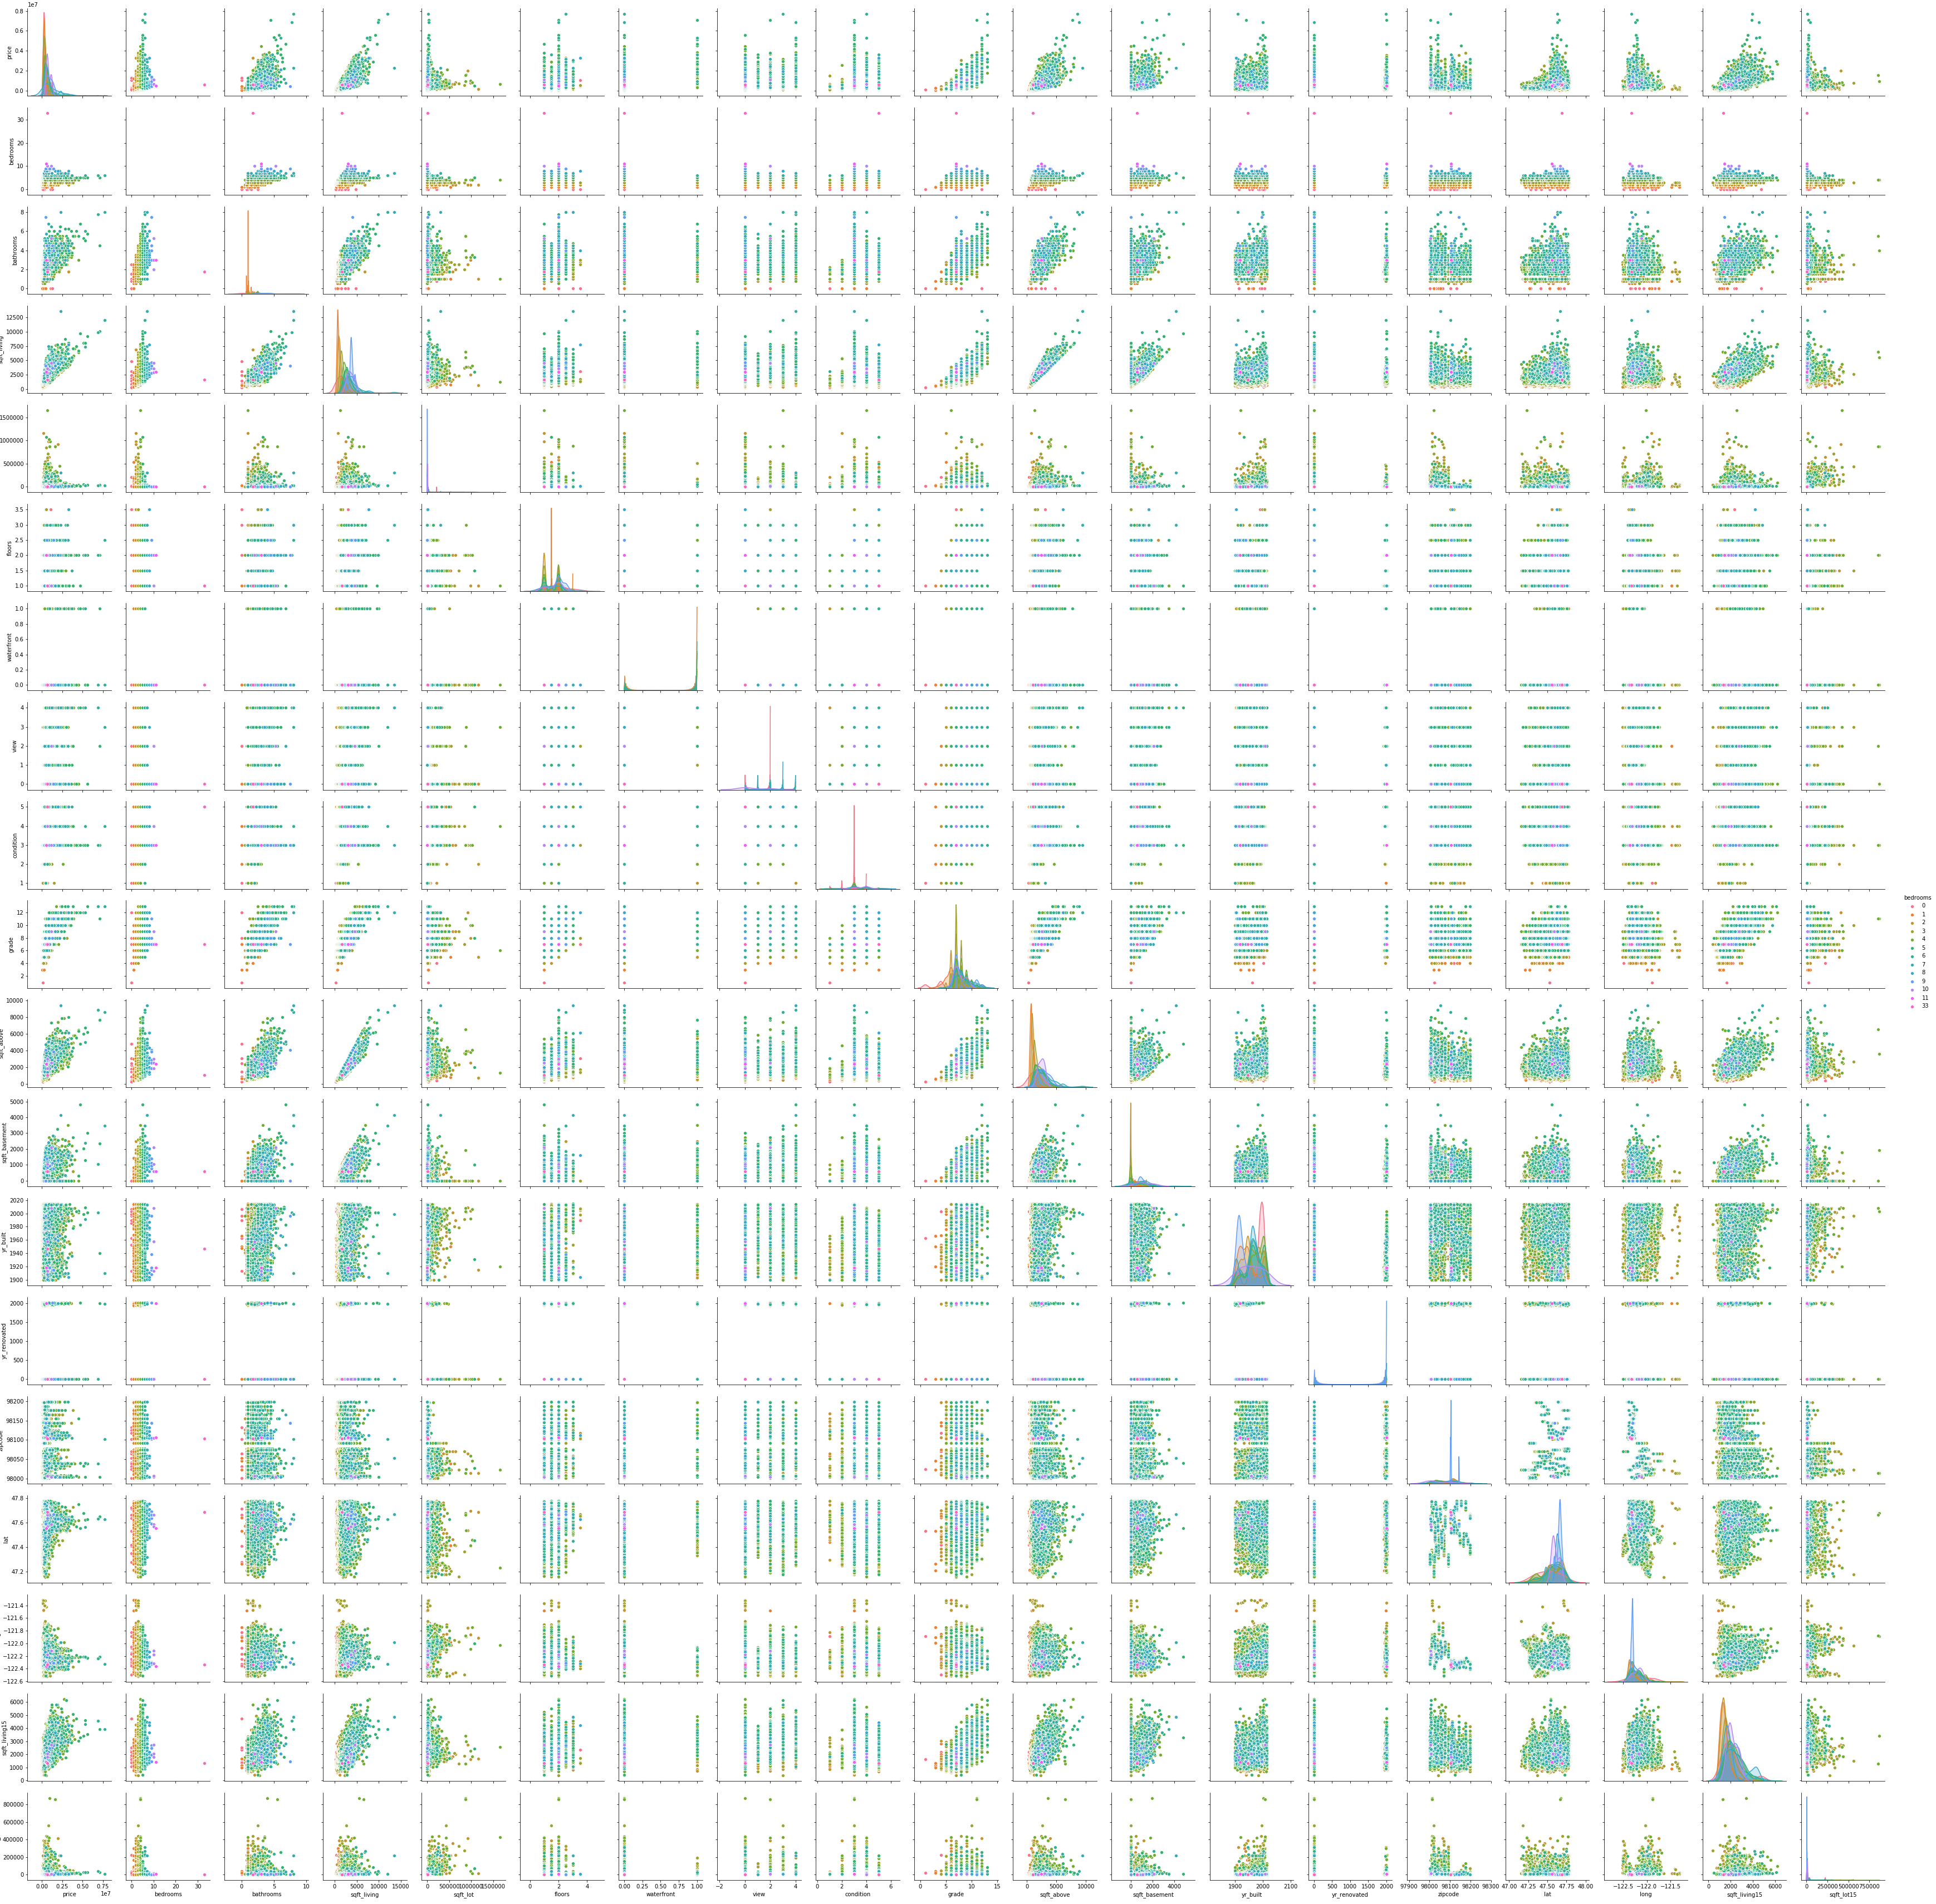

/home/thiago/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/thiago/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/thiago/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/thiago/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/bandwidths.py:20: RuntimeWarning: invalid value encountered in minimum
  return np.minimum(np.std(X, axis=0, ddof=1), IQR)
/home/thiago/anaconda3/lib/python3.7/site-packages/num

In [17]:
%matplotlib notebook
# https://seaborn.pydata.org/generated/seaborn.pairplot.html
g = sns.pairplot(house_data, hue='bedrooms', palette='husl')
g.savefig('house_data_pairplot.pdf')

Index(['bathrooms', 'bedrooms', 'condition', 'floors', 'grade', 'lat', 'long',
       'price', 'sqft_above', 'sqft_basement', 'sqft_living', 'sqft_living15',
       'sqft_lot', 'sqft_lot15', 'view', 'waterfront', 'yr_built',
       'yr_renovated', 'zipcode'],
      dtype='object')


<IPython.core.display.Javascript object>


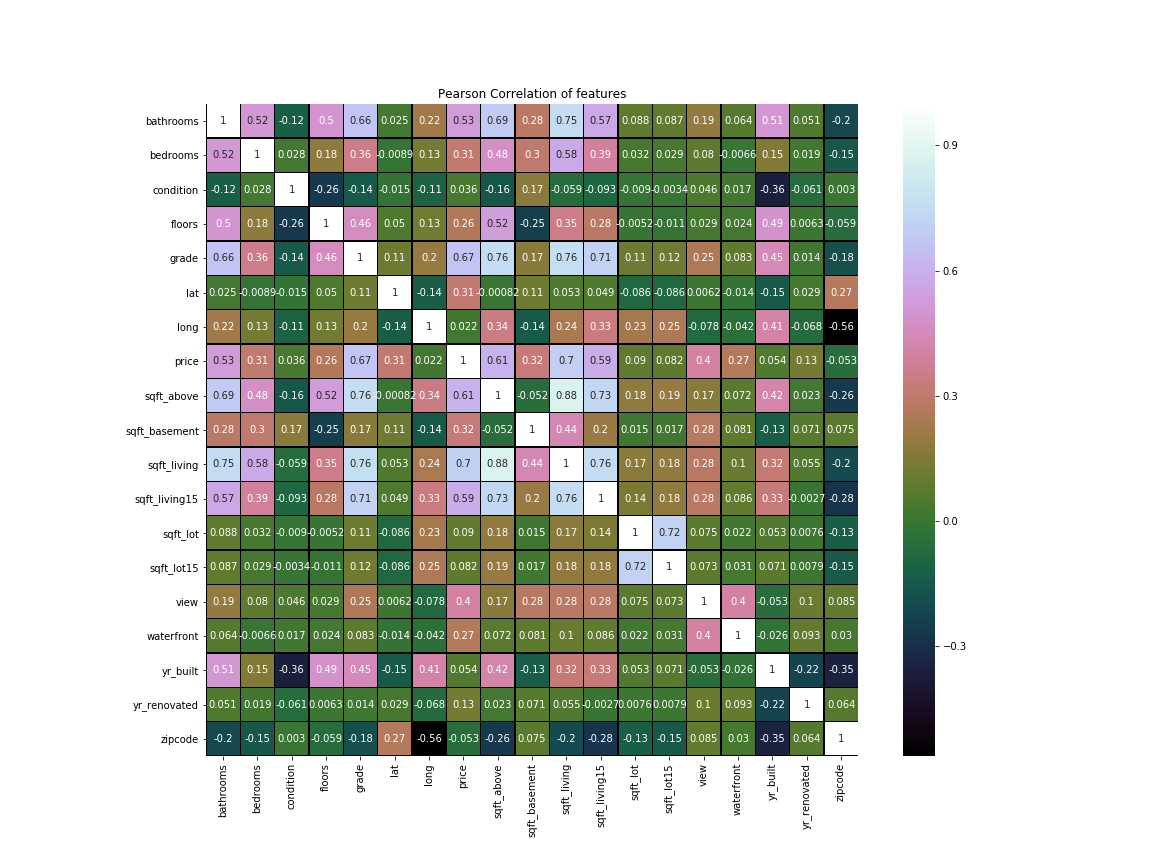

In [15]:
str_list = []

for colname, colvalue in house_data.iteritems():
    if type(colvalue[1]) == str:
        str_list.append(colname)

num_list = house_data.columns.difference(str_list)
print(num_list)

house_num = house_data[num_list]

f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation of features')

sns.heatmap(house_num.astype(float).corr(),linewidths=0.25,vmax=1.0, square=True, cmap="cubehelix", linecolor='k', annot=True)

<IPython.core.display.Javascript object>


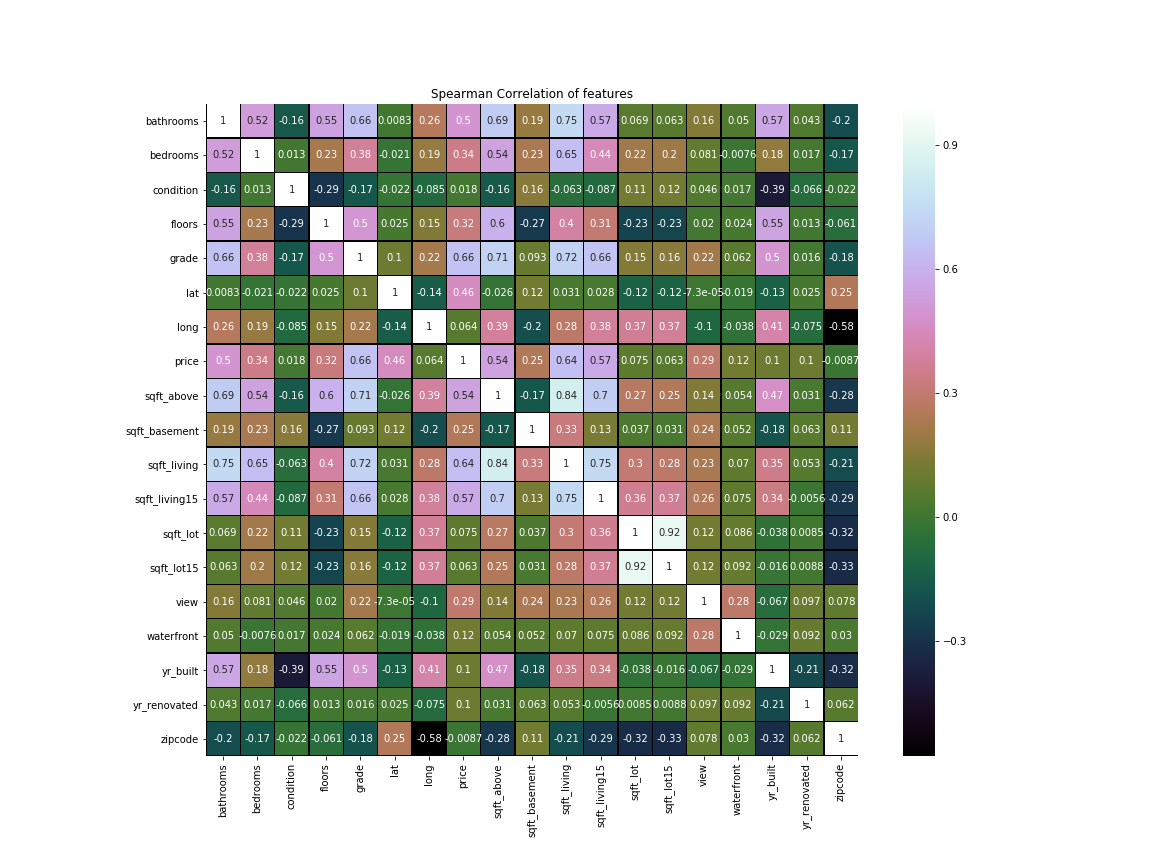

In [16]:
f, ax = plt.subplots(figsize=(16, 12))
plt.title('Spearman Correlation of features')

sns.heatmap(house_num.astype(float).corr(method='spearman'),linewidths=0.25,vmax=1.0, square=True, cmap="cubehelix", linecolor='k', annot=True)

## 2. Stability Selection via Randomized Lasso

In [16]:
Y = house_data.price.values

house_data = house_data.drop(['price'], axis=1)
X = house_data.values

colnames = house_data.columns

In [17]:
# Define dictionary to store our rankings
ranks = {}
# Create our function which stores the feature rankings to the ranks dictionary
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))

In [19]:
# Construct our Linear Regression model
lr = LinearRegression(normalize=True)
lr.fit(X,Y)
#stop the search when only the last feature is left
rfe = RFE(lr, n_features_to_select=1, verbose =3 )
rfe.fit(X,Y)
ranks["RFE"] = ranking(list(map(float, rfe.ranking_)), colnames, order=-1)

Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.


In [22]:
# Using Linear Regression
lr = LinearRegression(normalize=True)
lr.fit(X,Y)
ranks["LinReg"] = ranking(np.abs(lr.coef_), colnames)

# Using Ridge 
ridge = Ridge(alpha = 7)
ridge.fit(X,Y)
ranks['Ridge'] = ranking(np.abs(ridge.coef_), colnames)

# Using Lasso
lasso = Lasso(alpha=.05)
lasso.fit(X, Y)
ranks["Lasso"] = ranking(np.abs(lasso.coef_), colnames)

# Random Forest
rf = RandomForestRegressor(n_jobs=-1, n_estimators=50, verbose=3)
rf.fit(X,Y)
ranks["RF"] = ranking(rf.feature_importances_, colnames);

/home/intelie/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.5s


building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.3s finished


	Lasso	LinReg	Mean	RF	RFE	Ridge	rlasso/Stability	Mean
bedrooms	0.06	0.06	0.3	0.0	0.59	0.06	1.0	0.3
bathrooms	0.07	0.07	0.32	0.02	0.71	0.07	1.0	0.32
sqft_living	0.0	0.0	0.3	0.86	0.35	0.0	0.56	0.3
sqft_lot	0.0	0.0	0.17	0.04	0.0	0.0	1.0	0.17
floors	0.01	0.01	0.25	0.0	0.47	0.01	1.0	0.25
waterfront	0.97	0.97	0.83	0.11	1.0	0.94	1.0	0.83
view	0.09	0.09	0.34	0.03	0.76	0.09	1.0	0.34
condition	0.04	0.04	0.3	0.0	0.65	0.04	1.0	0.3
grade	0.16	0.16	0.56	1.0	0.88	0.16	1.0	0.56
sqft_above	0.0	0.0	0.2	0.07	0.29	0.0	0.81	0.2
sqft_basement	0.0	0.0	0.04	0.01	0.24	0.0	0.0	0.04
yr_built	0.0	0.0	0.27	0.08	0.53	0.0	1.0	0.27
yr_renovated	0.0	0.0	0.19	0.0	0.12	0.0	1.0	0.19
zipcode	0.0	0.0	0.24	0.04	0.41	0.0	1.0	0.24
lat	1.0	1.0	0.91	0.5	0.94	1.0	1.0	0.91
long	0.36	0.36	0.52	0.21	0.82	0.35	1.0	0.52
sqft_living15	0.0	0.0	0.21	0.09	0.18	0.0	1.0	0.21
sqft_lot15	0.0	0.0	0.18	0.03	0.06	0.0	1.0	0.18


/home/intelie/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/intelie/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


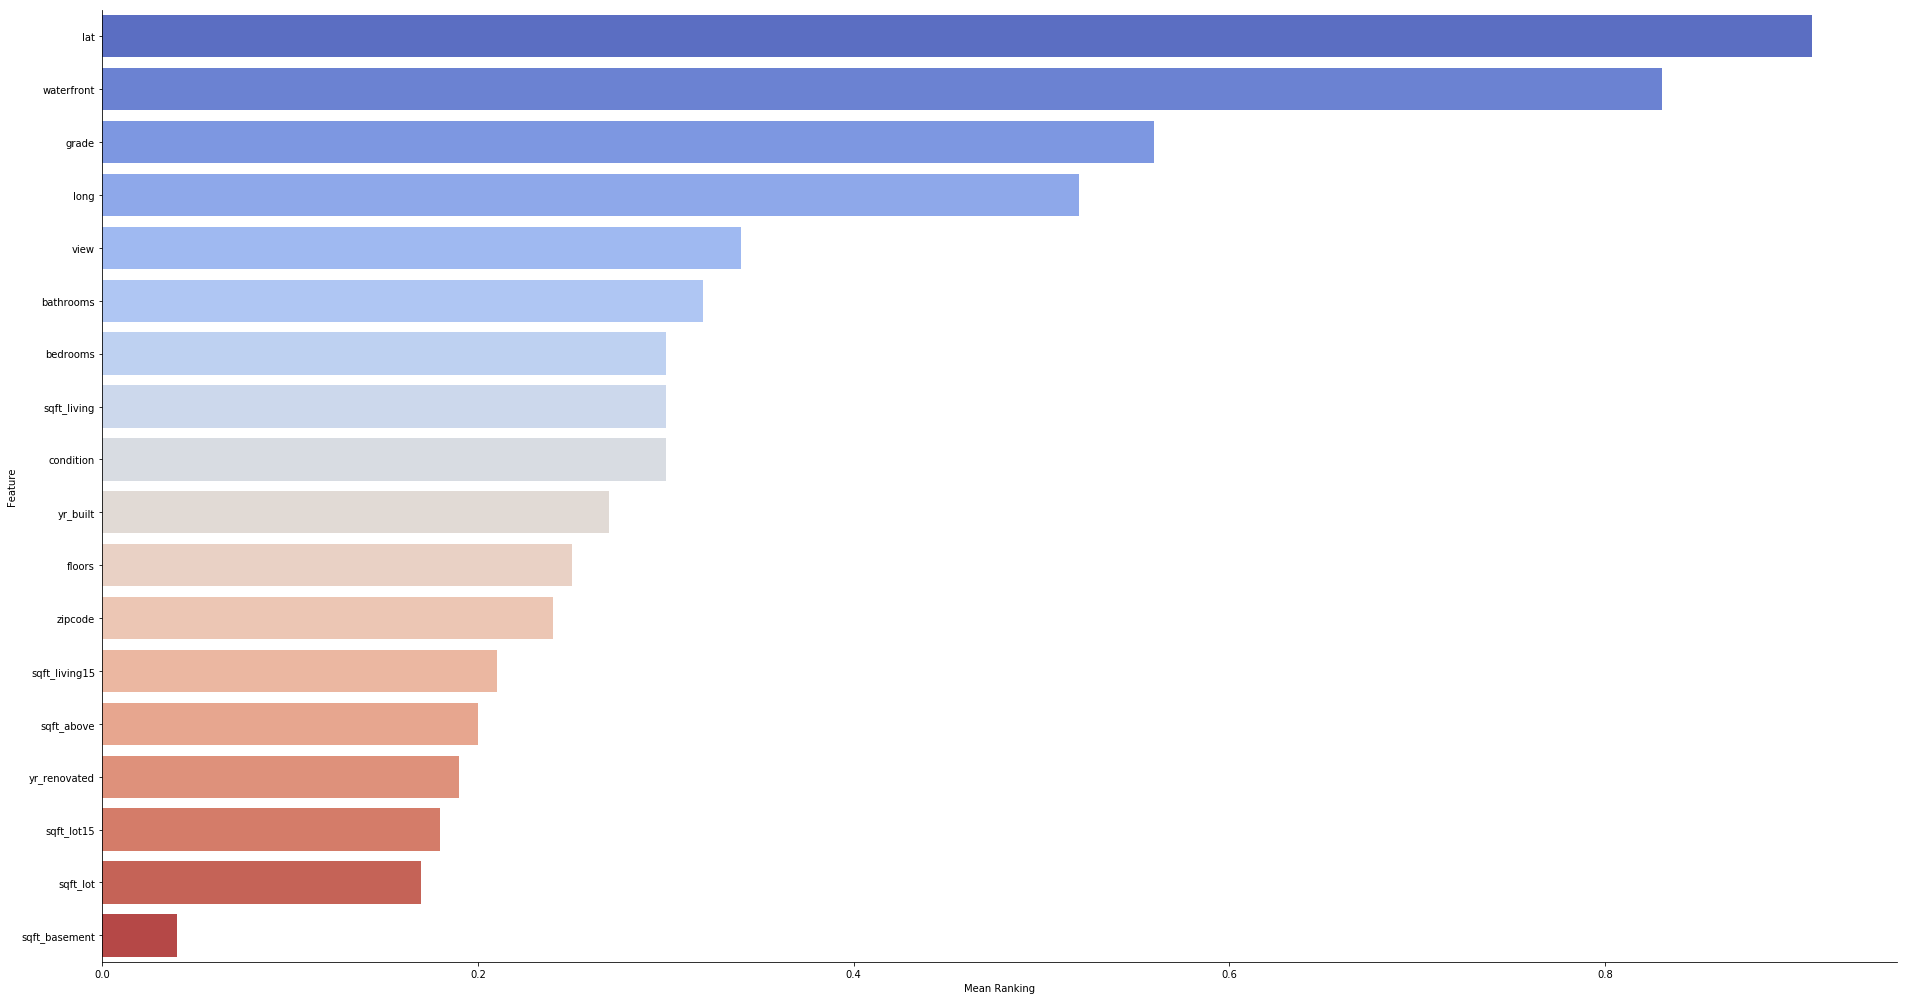

In [24]:
# Create empty dictionary to store the mean value calculated from all the scores
r = {}
for name in colnames:
    r[name] = round(np.mean([ranks[method][name] 
                             for method in ranks.keys()]), 2)
 
methods = sorted(ranks.keys())
ranks["Mean"] = r
methods.append("Mean")
 
print("\t%s" % "\t".join(methods))
for name in colnames:
    print("%s\t%s" % (name, "\t".join(map(str, 
                         [ranks[method][name] for method in methods]))))

# Put the mean scores into a Pandas dataframe
meanplot = pd.DataFrame(list(r.items()), columns= ['Feature','Mean Ranking'])

# Sort the dataframe
meanplot = meanplot.sort_values('Mean Ranking', ascending=False)

# Let's plot the ranking of the features
sns.factorplot(x="Mean Ranking", y="Feature", data = meanplot, kind="bar", 
               size=14, aspect=1.9, palette='coolwarm')